In [1]:
import os 
os.chdir('../src/')
print(os.getcwd())
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
from traffic_analysis.d00_utils.load_confs import load_parameters

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
params = load_parameters()
pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src


Read in video level data

In [6]:
xml_paths = ["C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\15_2019-06-29_13-01-03.094068_00001.01252.xml",
            "C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\14_2019-06-29_13-01-19.744908_00001.05900.xml"]

video_level_df = pd.read_csv("../data/carolinetemp/video_level_df.csv",
                    dtype={"camera_id": str},
                    parse_dates=["video_upload_datetime"])
del video_level_df['Unnamed: 0']

Read in frame level data

In [7]:
frame_level_df = pd.read_csv("../data/carolinetemp/frame_level_df.csv",
                    dtype={"camera_id": str},
                    converters={"bboxes": lambda x: [float(coord) for coord in x.strip("[]").split(", ")]}, 
                    parse_dates=["video_upload_datetime"])
del frame_level_df['Unnamed: 0']

Run evaluators

In [8]:
chunk_evaluator = ChunkEvaluator(annotation_xml_paths=xml_paths,
                                 params=params,
                                 video_level_df=video_level_df,
                                 frame_level_df = frame_level_df)
video_level_stats_df, video_level_diff_df = chunk_evaluator.evaluate_video_level()
frame_level_mAP_df = chunk_evaluator.evaluate_frame_level()

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src\traffic_analysis\d05_evaluation\video_level_evaluator.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  'n_videos': 'count'})
C:\Users\Caroline Wang\Anaconda3\envs\dssg\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
video_level_stats_df

,vehicle_type,stat,bias,MAE,RMSE,sd,n_videos
0,bus,counts,0.0,0.0,0.000000,0.000000,2
1,bus,starts,-0.5,0.5,0.707107,0.707107,2
2,bus,stops,0.0,0.0,0.000000,0.000000,2
3,car,counts,0.5,2.5,2.549510,3.535534,2
4,car,starts,1.5,1.5,2.121320,2.121320,2
5,car,stops,1.0,2.0,2.236068,2.828427,2
6,motorbike,counts,-2.0,2.0,2.000000,0.000000,2
7,motorbike,starts,0.0,0.0,0.000000,0.000000,2
8,motorbike,stops,0.0,0.0,0.000000,0.000000,2
9,truck,counts,-1.5,1.5,1.581139,0.707107,2


In [18]:
pivoted = (video_level_stats_df[['stat','vehicle_type', 'bias']]
           .pivot(index='vehicle_type', columns='stat', values='bias')
)

Index(['bus', 'car', 'motorbike', 'truck'], dtype='object', name='vehicle_type')

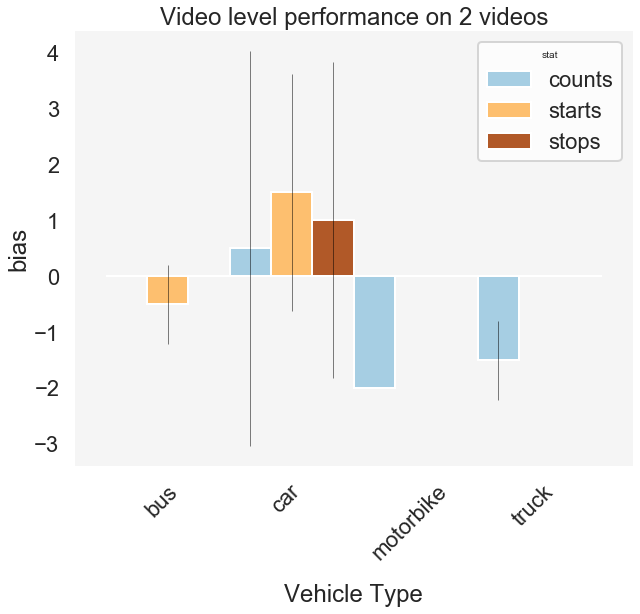

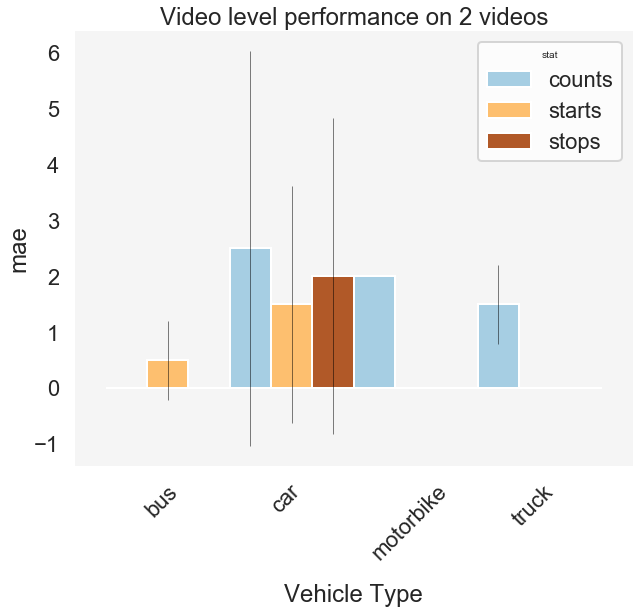

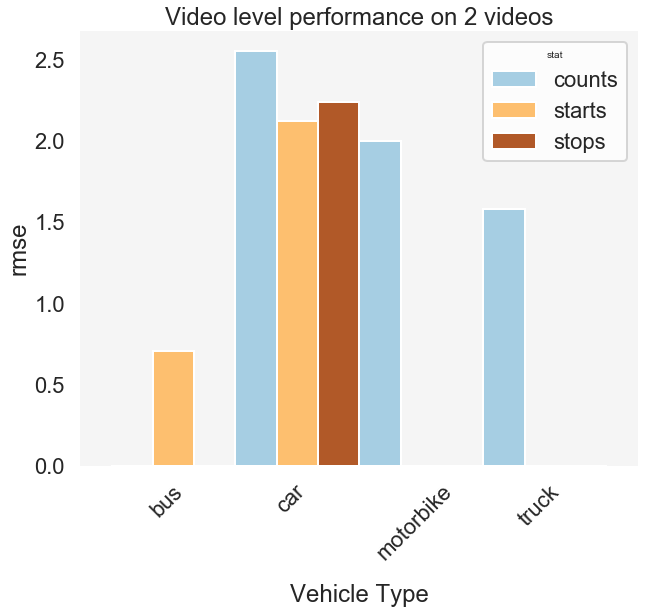

In [23]:
def plot_video_level_stats(video_level_stats_df: pd.DataFrame, 
                           metrics = {'bias':None, 'rmse':None, 'mae': None},
                           show_plots = True): 
    
    n_videos = video_level_stats_df['n_videos'].iloc[0]
    
    def style_show_save_plot(metric_type):
        ax.set_facecolor('whitesmoke')

        for side in ax.spines:
            ax.spines[side].set_visible(False)

        plt.title(f"Video level performance on {n_videos} videos")
        plt.xticks(rotation=45)
        plt.xlabel("Vehicle Type", labelpad=20)
        plt.ylabel(metric_type)
        if show_plots: 
            plt.show()
        if metrics[metric_type] is not None: 
            plt.savefig(metrics[metric_type])
        plt.close()
        
    
    if 'bias' in metrics: 
        bias_df = (video_level_stats_df[['stat','vehicle_type', 'bias']]
                    .pivot(index='vehicle_type', columns='stat', values='bias'))
        sd_df = (video_level_stats_df[['stat','vehicle_type', 'sd']]
                    .pivot(index='vehicle_type', columns='stat', values='sd')
                    .values.T)

        ax = bias_df.plot(kind='bar',
                            yerr=sd_df,
                            grid=False,
                            figsize=(10,8),
                            position=0.45,
                            colormap = 'Paired',
                            error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )
        style_show_save_plot(metric_type = 'bias')
        
    if 'mae' in metrics: 
        mae_df = (video_level_stats_df[['stat','vehicle_type', 'MAE']]
                    .pivot(index='vehicle_type', columns='stat', values='MAE'))
        sd_df = (video_level_stats_df[['stat','vehicle_type', 'sd']]
                    .pivot(index='vehicle_type', columns='stat', values='sd')
                    .values.T)
        ax = mae_df.plot(kind='bar',
                            yerr=sd_df,
                            grid=False,
                            figsize=(10,8),
                            position=0.45,
                            colormap = 'Paired',
                            error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )

        style_show_save_plot(metric_type = 'mae')
        
    if 'rmse' in metrics: 
        rmse_df = (video_level_stats_df[['stat','vehicle_type', 'RMSE']]
                    .pivot(index='vehicle_type', columns='stat', values='RMSE'))

        ax = rmse_df.plot(kind='bar',
                            grid=False,
                            figsize=(10,8),
                            position=0.45,
                            colormap = 'Paired',
#                             error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )
        style_show_save_plot(metric_type='rmse')
    return

plot_video_level_stats(video_level_stats_df, 
                       metrics = {'bias': "../data/plots/video_bias.pdf",
                                  'rmse': "../data/plots/video_rmse.pdf",
                                   'mae': "../data/plots/video_mae.pdf"},
                       show_plots = True
                       )


Possible line chart for frame level

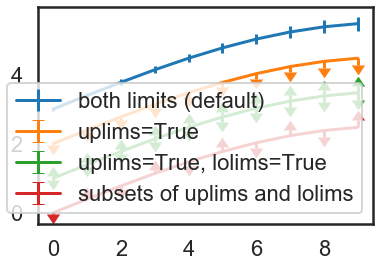

In [7]:
fig = plt.figure()
x = np.arange(10)
y = 2.5 * np.sin(x / 20 * np.pi)
yerr = np.linspace(0.05, 0.2, 10)

#line1
plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')
#line2
plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')
#line3
plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
             label='uplims=True, lolims=True')
#line4
upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5
plt.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits,
             label='subsets of uplims and lolims')

plt.legend(loc='lower right')